### The following dataset is taken from Kaggle.

#### Introduction
The Mobile phone activity dataset is composed by one week of Call Details Records (CDRs) from the city of Milan and the Province of Trentino (Italy).

#### Description of the dataset
Every time a user engages a telecommunication interaction, a Radio Base Station (RBS) is assigned by the operator and delivers the communication through the network. Then, a new CDR is created recording the time of the interaction and the RBS which handled it. The following activities are present in the dataset:

- received SMS
- sent SMS
- incoming calls
- outgoing calls
- Internet activity

#### Loading the dataset and creating a dataframe

In [57]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').option('timestampFormat', 'MM/d/yyyy HH:mm').load('C:\MS CS\Semester3\Big Data\mobile-phone-activity\*.csv')
df.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- CellID: integer (nullable = true)
 |-- countrycode: integer (nullable = true)
 |-- provinceName: string (nullable = true)
 |-- cell2Province: double (nullable = true)
 |-- Province2cell: double (nullable = true)
 |-- smsin: double (nullable = true)
 |-- smsout: double (nullable = true)
 |-- callin: double (nullable = true)
 |-- callout: double (nullable = true)
 |-- internet: double (nullable = true)



#### Cleaning up the data - throwing away data with country code 0

In [94]:
cleanedData = df.filter(df.countrycode > 0)
cleanedData.count()

6455521

#### Summary Statistics

In [59]:
for column in df.columns:
    if column != "datetime" and column != "provinceName":
        df.describe(column).show()

+-------+------------------+
|summary|            CellID|
+-------+------------------+
|  count|           7340025|
|   mean| 5185.996236797559|
| stddev|2725.0560844847546|
|    min|                 1|
|    max|             10000|
+-------+------------------+

+-------+------------------+
|summary|       countrycode|
+-------+------------------+
|  count|           7340025|
|   mean|385.30124979138355|
| stddev|4762.7411433001225|
|    min|                 0|
|    max|             97259|
+-------+------------------+

+-------+------------------+
|summary|     cell2Province|
+-------+------------------+
|  count|           4505081|
|   mean|0.7463889995540853|
| stddev|3.7141639278375935|
|    min|               0.0|
|    max|          338.0897|
+-------+------------------+

+-------+------------------+
|summary|     Province2cell|
+-------+------------------+
|  count|           4818105|
|   mean|0.7126784532923495|
| stddev|3.6396254864391295|
|    min|               0.0|
|    max|  

#### Analysing the CellID who has most calls, sms, and internet usage.

In [60]:
cleanedData.createOrReplaceTempView("mobiledata_table")
spark.sql("select CellID, 'maximum sms out' from mobiledata_table where smsout in (select max(smsout) from mobiledata_table)").show()
spark.sql("select CellID, 'maximum call out' from mobiledata_table where callout in (select max(callout) from mobiledata_table)").show()
spark.sql("select CellID, 'maximum internet usage' from mobiledata_table where internet in (select max(internet) from mobiledata_table)").show()

+------+---------------+
|CellID|maximum sms out|
+------+---------------+
|  4948|maximum sms out|
+------+---------------+

+------+----------------+
|CellID|maximum call out|
+------+----------------+
|  5059|maximum call out|
+------+----------------+

+------+----------------------+
|CellID|maximum internet usage|
+------+----------------------+
|  5161|  maximum internet ...|
+------+----------------------+



#### Correlation Matrix
Dropping out NaN values and considering data whose internet value > 1

In [116]:
from pyspark.ml.stat import Correlation
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import numpy as np
import sys

cleanedDF = cleanedData.drop("datetime","CellID","countrycode","provinceName")
cleanedDF = cleanedDF.dropna().filter(cleanedDF.internet > 1)
vector_data = cleanedDF.rdd.map(lambda data: Vectors.dense([c for c in data]))
correlation_matrix = Statistics.corr(vector_data, method="pearson")

#### Feature pairs and their correlation coefficients

In [117]:
feats = []
correlationpoints = {}
f = open('features.txt')
for i,feat1 in enumerate(f):
    if i==0 or i==1 or i==2 or i==3:
        continue
    feats.append(feat1)

for j, feat2 in enumerate(feats):
    for k, feat3 in enumerate(feats):
        print(feat2.strip(),',',feat3.strip(),':',correlation_matrix[j,k])
        correlationpoints[feat2.strip()+','+feat3.strip()]= correlation_matrix[j,k]

cell2Province , cell2Province : 1.0
cell2Province , Province2cell : 0.957878755893
cell2Province , smsin : 0.029504314584
cell2Province , smsout : 0.0236913169321
cell2Province , callin : 0.0356233815365
cell2Province , callout : 0.0356576762858
cell2Province , internet : 0.0140887229859
Province2cell , cell2Province : 0.957878755893
Province2cell , Province2cell : 1.0
Province2cell , smsin : 0.0296687266286
Province2cell , smsout : 0.0238451623729
Province2cell , callin : 0.035668984983
Province2cell , callout : 0.0358171165989
Province2cell , internet : 0.0146999641726
smsin , cell2Province : 0.029504314584
smsin , Province2cell : 0.0296687266286
smsin , smsin : 1.0
smsin , smsout : 0.922025138993
smsin , callin : 0.942273184399
smsin , callout : 0.936553295707
smsin , internet : 0.87041175209
smsout , cell2Province : 0.0236913169321
smsout , Province2cell : 0.0238451623729
smsout , smsin : 0.922025138993
smsout , smsout : 1.0
smsout , callin : 0.854145648221
smsout , callout : 0.852

#### Taking only the features whose correlation coefficient lies between 0.6 and 0.9

In [118]:
for key in correlationpoints:
    if correlationpoints[key] > 0.6 and correlationpoints[key] < 0.9:
        print(key, ':', correlationpoints[key])

smsin,internet : 0.87041175209
smsout,callin : 0.854145648221
smsout,callout : 0.852019978135
smsout,internet : 0.843319093677
callin,smsout : 0.854145648221
callin,internet : 0.827125557303
callout,smsout : 0.852019978135
callout,internet : 0.823780356228
internet,smsin : 0.87041175209
internet,smsout : 0.843319093677
internet,callin : 0.827125557303
internet,callout : 0.823780356228


#### Training the model
Considering the users who used internet the most

Making predictions based on smsin, smsout, callin and callout

90% is the training data and 10% is the test data

In [123]:
from pyspark.ml.feature import VectorAssembler

def prepare_data(dframe, predictors, target):
    assembler = VectorAssembler(inputCols=predictors, outputCol="features")
    output = assembler.transform(dframe)
    return output.select("features", target).withColumnRenamed(target, "label")

internetMax = cleanedDF.filter(cleanedDF.internet > 4000)
prepped = prepare_data(internetMax,
    ["smsin", "callin", "smsout", "callout"],
    "internet")

#prepped.show()
(trainingData, testData) = prepped.randomSplit([0.9, 0.1])
trainingData.count()

1253

In [124]:
from pyspark.ml.regression import LinearRegression

rf = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
model = rf.fit(trainingData)
predictions = model.transform(testData)

evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1289.29


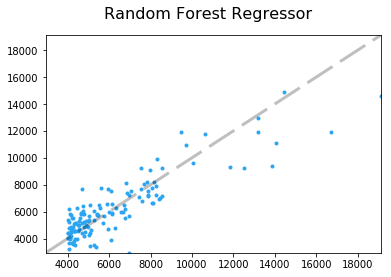

In [125]:
import matplotlib.pyplot as plt

p_df = predictions.select("label", "prediction").toPandas()

plt.suptitle('Random Forest Regressor', fontsize=16)

minval = p_df[['label', 'prediction']].min().min()
maxval = p_df[['label', 'prediction']].max().max()
plt.axis([minval, maxval, minval, maxval])

plt.plot(p_df['label'], p_df['prediction'], '.', color='#2ba5f1')
plt.plot(range(int(minval), int(maxval)), range(int(minval), int(maxval)), lw=3, dashes=(10, 3), color='#000000', alpha=0.25, label='Ideal Predictor')
plt.show()

#### Plotting Internet Activity

Plotting the Internet activity of people in the following areas

- MILANO
- PAVIA
- TRENTO

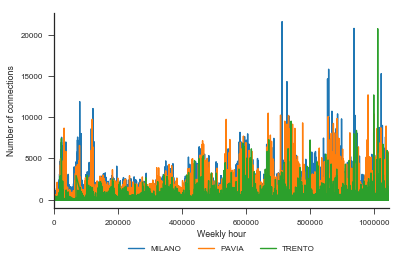

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats, integrate
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("paper")

df_cdrs = pd.DataFrame({})
for i in range(1,8):
    mobiledf = pd.read_csv('C:/MS CS/Semester3/Big Data/mobile-phone-activity/sms-call-internet-mi-2013-11-0{}.csv'.format(i), parse_dates=['datetime'])
    df_cdrs = df_cdrs.append(mobiledf)
    
df_cdrs=df_cdrs.fillna(0)
df_cdrs['sms'] = df_cdrs['smsin'] + df_cdrs['smsout']
df_cdrs['calls'] = df_cdrs['callin'] + df_cdrs['callout']

df_cdrs_internet = df_cdrs[['datetime', 'CellID', 'internet', 'calls', 'sms']].groupby(['datetime', 'CellID'], as_index=False).sum()
df_cdrs_internet['hour'] = df_cdrs_internet.datetime.dt.hour+24*(df_cdrs_internet.datetime.dt.day-1)
df_cdrs_internet = df_cdrs_internet.set_index(['hour']).sort_index()

f = plt.figure()

ax = df_cdrs[df_cdrs.provinceName=='MILANO']['internet'].plot(label='MILANO')
df_cdrs[df_cdrs.provinceName=='PAVIA']['internet'].plot(ax=ax, label='PAVIA')
df_cdrs[df_cdrs.provinceName=='TRENTO']['internet'].plot(ax=ax, label='TRENTO')
plt.xlabel("Weekly hour")
plt.ylabel("Number of connections")
sns.despine()

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)
plt.show()